In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import json
import os
import pickle

In [5]:
# Set up data directory
data_dir = os.path.join(os.getcwd(), 'processed_data')

# Create data directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Created processed data directory")

# Try to load the processed data
print("Attempting to load processed data...")

try:
    # Load numpy arrays
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Processed data files not found.")
    print("Please ensure you have run the data processing script first")
    print("and that the processed data files exist in the 'processed_data' directory.")
    raise

# Load metadata
with open(os.path.join(data_dir, 'data_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Load complete dataset for additional info
complete_data_file = os.path.join(data_dir, 'composer_classification_data.pkl')
if os.path.exists(complete_data_file):
    with open(complete_data_file, 'rb') as f:
        complete_data = pickle.load(f)
    composer_names = complete_data.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])
else:
    composer_names = metadata.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])

print(f"Data loaded successfully!")
print(f"Composers: {composer_names}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Attempting to load processed data...
Data loaded successfully!
Data loaded successfully!
Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
X_train shape: (336, 128, 500)
X_val shape: (72, 128, 500)
X_test shape: (72, 128, 500)


In [6]:
# Data is already in the right format for CNN (samples, height, width, channels)
# Add channel dimension if not present
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

print("Data prepared for CNN:")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_val_cnn shape: {X_val_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")

# Create data dictionary for easy access
cnn_data = {
    'X_train': X_train_cnn,
    'X_val': X_val_cnn,
    'X_test': X_test_cnn,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'composer_names': composer_names
}

Data prepared for CNN:
X_train_cnn shape: (336, 128, 500, 1)
X_val_cnn shape: (72, 128, 500, 1)
X_test_cnn shape: (72, 128, 500, 1)


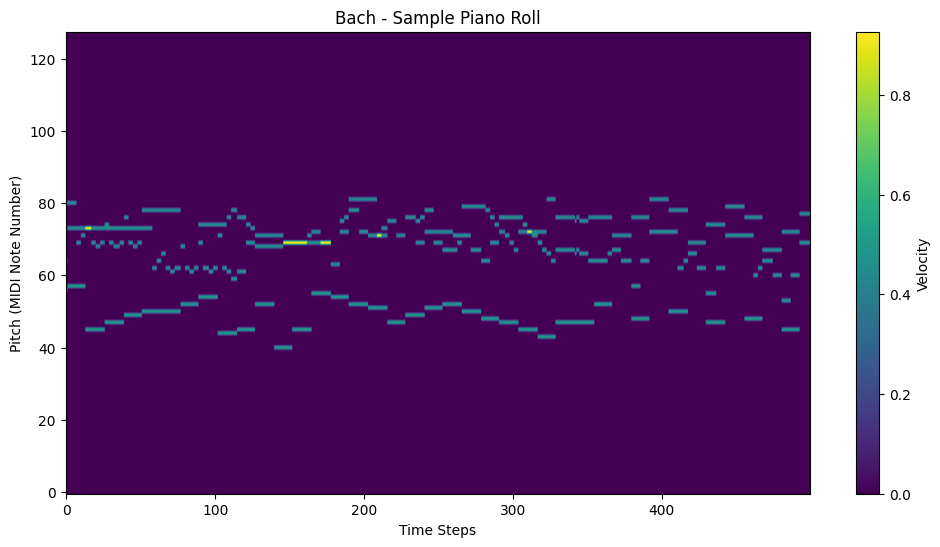

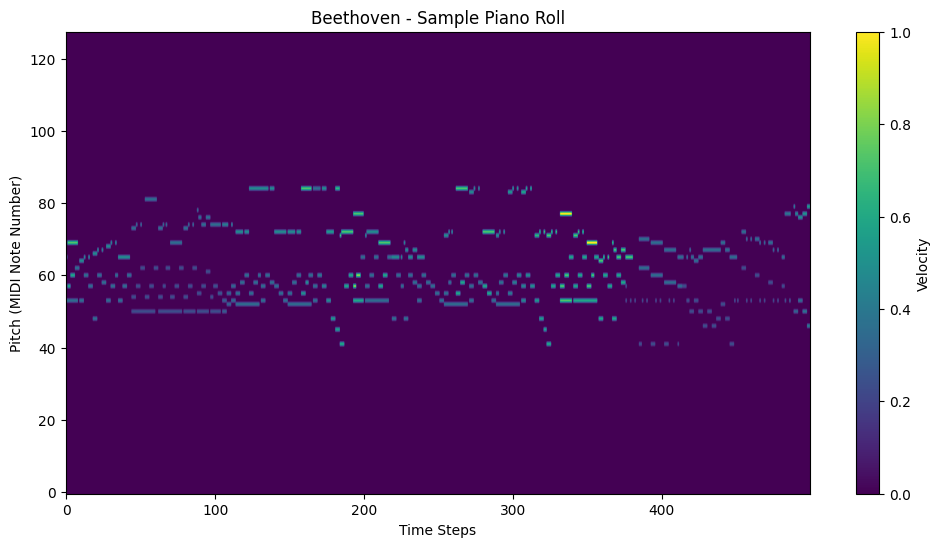

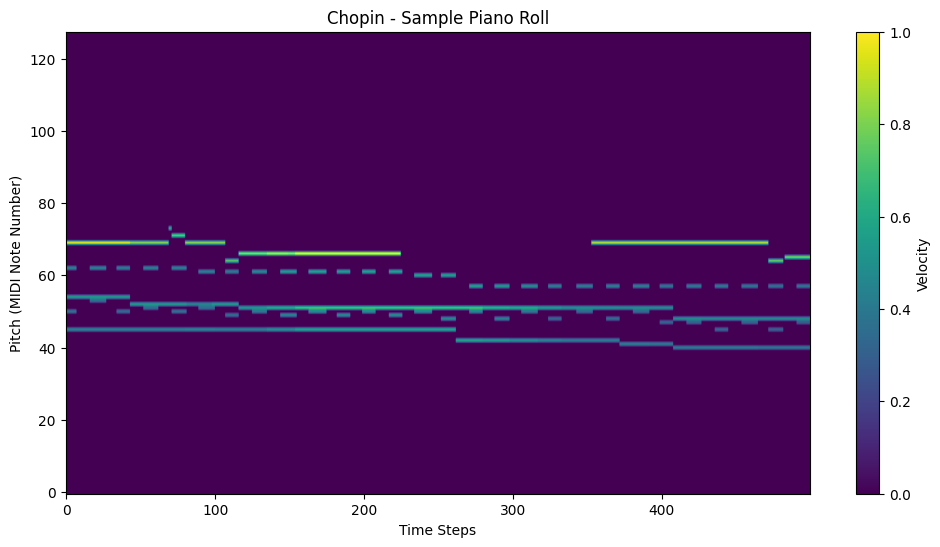

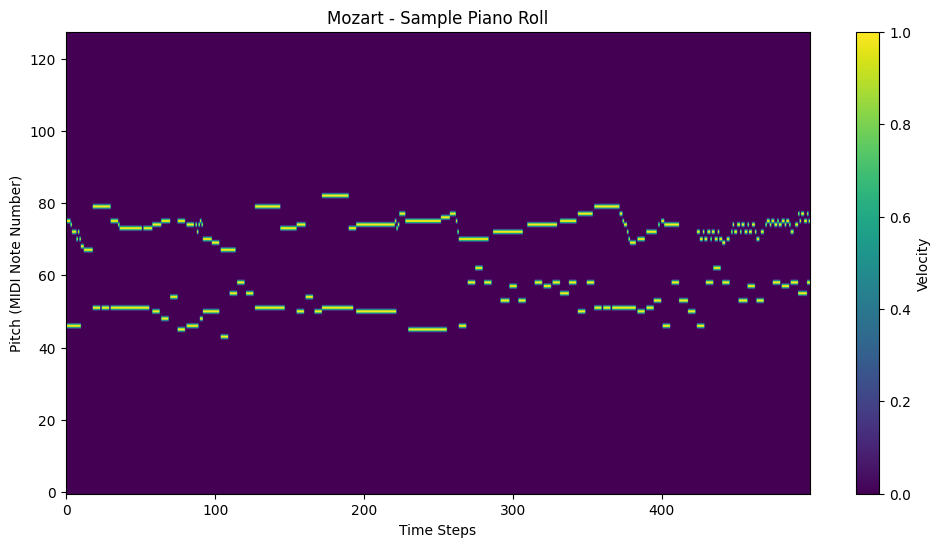

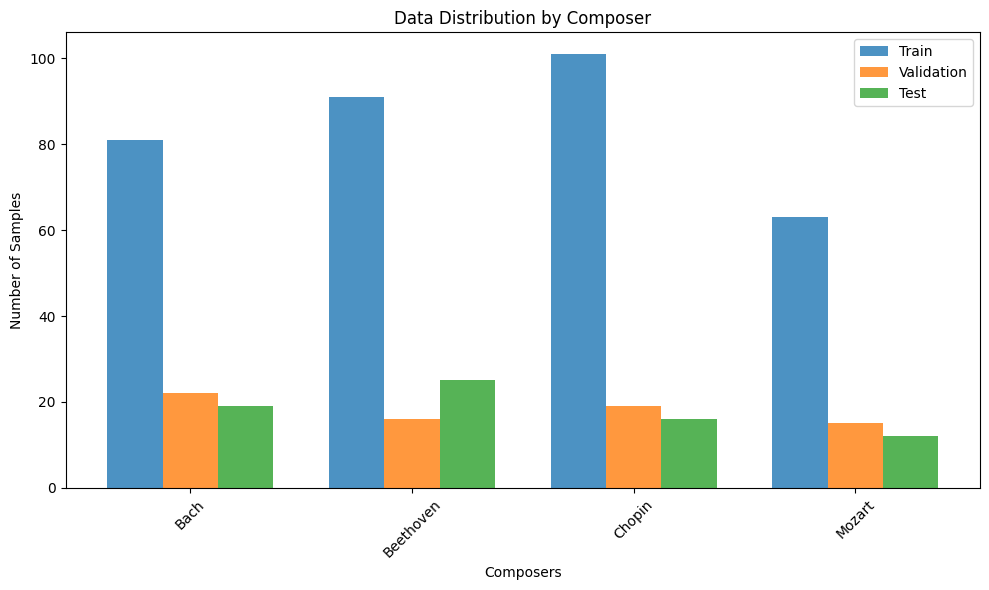

In [7]:
# Visualize a sample piano roll
def plot_piano_roll(piano_roll, title="Piano Roll Sample"):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll.squeeze(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.title(title)
    plt.show()

# Plot samples from each composer
for i, composer in enumerate(composer_names):
    # Find first sample from this composer
    composer_indices = np.where(cnn_data['y_train'] == i)[0]
    if len(composer_indices) > 0:
        sample_idx = composer_indices[0]
        piano_roll = cnn_data['X_train'][sample_idx]
        plot_piano_roll(piano_roll, f"{composer} - Sample Piano Roll")

# Analyze data distribution
plt.figure(figsize=(10, 6))
train_dist = np.bincount(cnn_data['y_train'])
val_dist = np.bincount(cnn_data['y_val'])
test_dist = np.bincount(cnn_data['y_test'])

x = np.arange(len(composer_names))
width = 0.25

plt.bar(x - width, train_dist, width, label='Train', alpha=0.8)
plt.bar(x, val_dist, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_dist, width, label='Test', alpha=0.8)

plt.xlabel('Composers')
plt.ylabel('Number of Samples')
plt.title('Data Distribution by Composer')
plt.xticks(x, composer_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Define CNN model parameters
input_shape = cnn_data['X_train'].shape[1:]
num_classes = len(composer_names)
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile model
model = create_cnn_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Input shape: (128, 500, 1)
Number of classes: 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 500, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 500, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 250, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 250, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 62, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 31, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,506,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,900,228 (125.50 MB)

 Trainable params: 32,898,244 (125.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [9]:
# Set training parameters
epochs = 20
batch_size = 32

# Train the model
print("Starting training...")
history = model.fit(
    cnn_data['X_train'],
    cnn_data['y_train'],
    validation_data=(cnn_data['X_val'], cnn_data['y_val']),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 621ms/step - accuracy: 0.3608 - loss: 2.0725 - val_accuracy: 0.2083 - val_loss: 2.7443
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 621ms/step - accuracy: 0.3608 - loss: 2.0725 - val_accuracy: 0.2083 - val_loss: 2.7443
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.6704 - loss: 0.9059 - val_accuracy: 0.2361 - val_loss: 3.2005
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.6704 - loss: 0.9059 - val_accuracy: 0.2361 - val_loss: 3.2005
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.7457 - loss: 0.6300 - val_accuracy: 0.2500 - val_loss: 2.8633
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.7457 - loss: 0.6300 - val_accuracy: 0.2500 - val_loss: 2.8633
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - accuracy: 0.8825 - loss: 0.3778 - val_accuracy: 0.2222 - val_loss: 2.2542
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - accuracy: 0.8825 - loss: 0.37

Test Accuracy: 0.3750
Test Loss: 3.7759
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.00      0.00      0.00        19
   Beethoven       0.43      0.92      0.58        25
      Chopin       0.00      0.00      0.00        16
      Mozart       0.22      0.33      0.27        12

    accuracy                           0.38        72
   macro avg       0.16      0.31      0.21        72
weighted avg       0.18      0.38      0.25        72


Classification Report:
              precision    recall  f1-score   support

        Bach       0.00      0.00      0.00        19
   Beethoven       0.43      0.92      0.58        25
      Chopin       0.00      0.00      0.00        16
      Mozart       0.22      0.33      0.27        12

    accuracy                           0.38        72
   macro avg       0.16      0.31      0.21        72
weighted avg       

/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

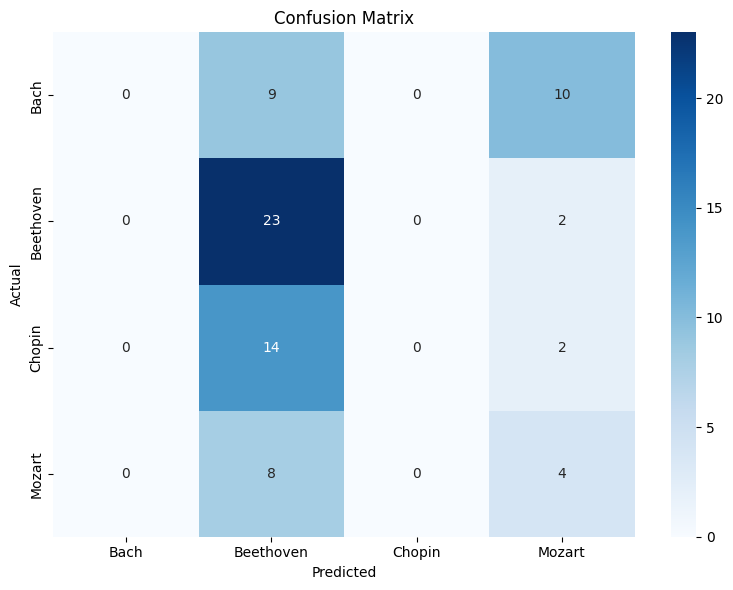

In [10]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(cnn_data['X_test'], cnn_data['y_test'], verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(cnn_data['X_test'])
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(cnn_data['y_test'], y_pred_classes, 
                          target_names=composer_names))

# Confusion matrix
cm = confusion_matrix(cnn_data['y_test'], y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

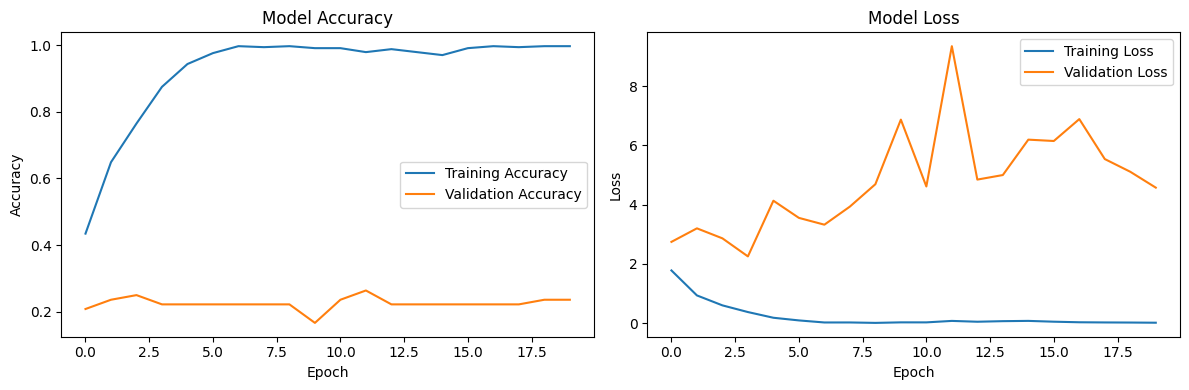

Final Training Accuracy: 0.9970
Final Validation Accuracy: 0.2361
Final Training Loss: 0.0170
Final Validation Loss: 4.5741


In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [12]:
# Create a more robust CNN model with additional techniques
def create_robust_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(cnn_data['y_train']),
    y=cnn_data['y_train']
)
class_weight_dict = dict(zip(np.unique(cnn_data['y_train']), class_weights))

# Create and compile robust model
robust_model = create_robust_cnn_model(input_shape, num_classes)
robust_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

robust_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 128, 500, 1)    │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 500, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 500, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 500, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 500, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 250, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 250, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 250, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 250, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 125, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 126976)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    65,012,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 65,435,880 (249.62 MB)

 Trainable params: 65,433,446 (249.61 MB)

 Non-trainable params: 2,434 (9.51 KB)

In [13]:
# Set up callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the robust model
print("Training robust model with balanced class weights...")
history_robust = robust_model.fit(
    cnn_data['X_train'], 
    cnn_data['y_train'],
    validation_data=(cnn_data['X_val'], cnn_data['y_val']),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Training robust model with balanced class weights...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3313 - loss: 2.1461
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to best_cnn_model.h5

Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to best_cnn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3322 - loss: 2.1377 - val_accuracy: 0.2083 - val_loss: 2.9391 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4563 - loss: 1.6038
Epoch 2: val_accuracy did not improve from 0.20833
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4563 - loss: 1.6002 - val_accuracy: 0.2083 - val_loss: 3.6179 - learning_rate: 0.0010
Epoch 3/50

Epoch 2: val_accuracy did not improve from 0.20833
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4563 - loss: 1.6002 - val_accuracy: 0.2083 - val_loss: 3.6179 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4800 - loss: 1.3789
Epoch 3: val_accuracy did not improve from 0.20833
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4844 - loss: 1.3754 - val_accuracy: 0.2083 - val_loss: 3.7603 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.20833
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6936 - loss: 0.9752 - val_accuracy: 0.2222 - val_loss: 2.5982 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7564 - loss: 0.7779
Epoch 6: val_accuracy did not improve from 0.22222
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7558 - loss: 0.7789 - val_accuracy: 0.2222 - val_loss: 3.0619 - learning_rate: 0.0010
Epoch 7/50

Epoch 6: val_accuracy did not improve from 0.22222
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7558 - loss: 0.7789 - val_accuracy: 0.2222 - val_loss: 3.0619 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7621 - loss: 0.5785
Epoch 7: val_accuracy did not improve from 0.22222
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7608 - loss: 0.5859 - val_accuracy: 0.2222 - val_loss: 2.5774 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.22222
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.2500 - val_loss: 4.5451 - learning_rate: 5.0000e-04
Epoch 25/50
Epoch 25/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9994 - loss: 0.0111
Epoch 25: val_accuracy improved from 0.25000 to 0.26389, saving model to best_cnn_model.h5

Epoch 25: val_accuracy improved from 0.25000 to 0.26389, saving model to best_cnn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9992 - loss: 0.0113 - val_accuracy: 0.2639 - val_loss: 4.2003 - learning_rate: 5.0000e-04
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
Training completed!
Training completed!


Robust CNN Model - Test Accuracy: 0.3472
Robust CNN Model - Test Loss: 1.8797
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

Robust CNN Model - Classification Report:
              precision    recall  f1-score   support

        Bach       0.00      0.00      0.00        19
   Beethoven       0.35      1.00      0.52        25
      Chopin       0.00      0.00      0.00        16
      Mozart       0.00      0.00      0.00        12

    accuracy                           0.35        72
   macro avg       0.09      0.25      0.13        72
weighted avg       0.12      0.35      0.18        72


Robust CNN Model - Classification Report:
              precision    recall  f1-score   support

        Bach       0.00      0.00      0.00        19
   Beethoven       0.35      1.00      0.52        25
      Chopin       0.00      0.00      0.00        16
      Mozart       0.00      0.00      0.00        12

    accuracy                           0.35        

/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

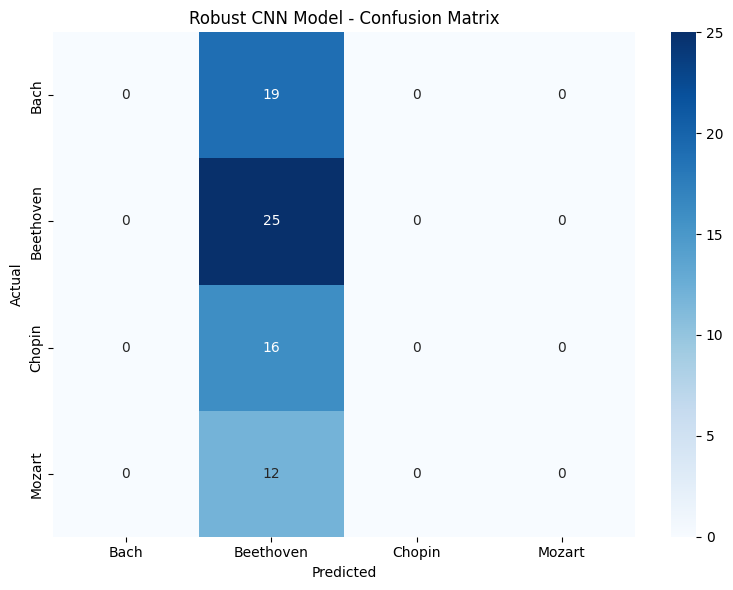

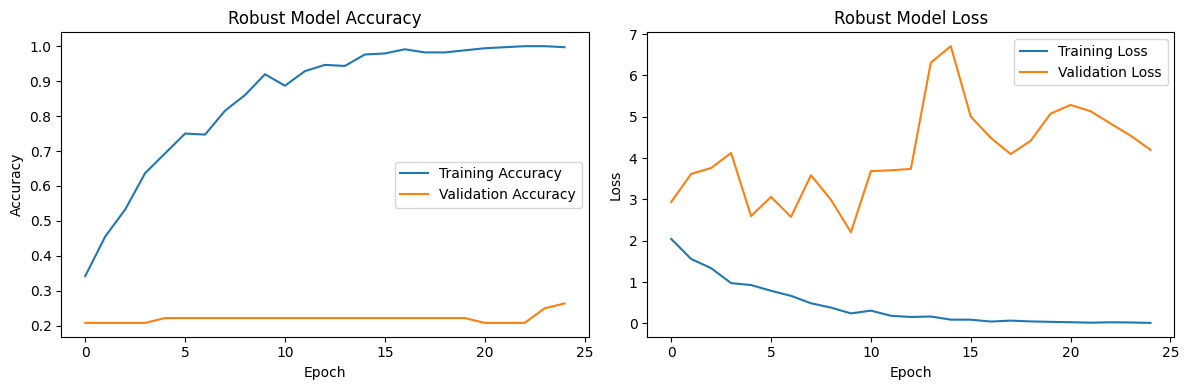

In [14]:
# Evaluate robust model
test_loss_robust, test_accuracy_robust = robust_model.evaluate(cnn_data['X_test'], cnn_data['y_test'], verbose=0)
print(f"Robust CNN Model - Test Accuracy: {test_accuracy_robust:.4f}")
print(f"Robust CNN Model - Test Loss: {test_loss_robust:.4f}")

# Make predictions
y_pred_robust = robust_model.predict(cnn_data['X_test'])
y_pred_classes_robust = np.argmax(y_pred_robust, axis=1)

# Classification report
print("\nRobust CNN Model - Classification Report:")
print(classification_report(cnn_data['y_test'], y_pred_classes_robust, 
                          target_names=composer_names))

# Confusion matrix
cm_robust = confusion_matrix(cnn_data['y_test'], y_pred_classes_robust)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_robust, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('Robust CNN Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history_robust.history['accuracy'], label='Training Accuracy')
ax1.plot(history_robust.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Robust Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history_robust.history['loss'], label='Training Loss')
ax2.plot(history_robust.history['val_loss'], label='Validation Loss')
ax2.set_title('Robust Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()